In [101]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import datetime as dt
from collections import defaultdict

In [ ]:
conn = wrds.Connection()

In [103]:
def calculate_assetg(group):
    # Shift within the group
    group['at'] = group['at'].shift(1)
    group['at_lag3'] = group['at'].shift(3)  
    group['at_lag2'] = group['at'].shift(2)
    group['at_lag1'] = group['at'].shift(1)


    # Calculate ASSETG
    group['ASSETG'] = (group['at_lag1'] - group['at_lag2']) / group['at_lag2']
    group['L2ASSETG'] = (group['at_lag2'] - group['at_lag3']) / group['at_lag3']
    return group

grabs total asset data, drops and reformats columns, removes SIC codes between 6000 & 6999 (financial) and drops all NA & 0 at values. Performs ASSETG calculations

* Date range: 1960-06/2005-06
* Company Codes: SIC
* Consolidation Level: consolidated: Parent and Subsidiary accounts combined
* Industry format: INDL: industrial
* Data format: STD: standardized
* Population source: D: domestic
* SELECT: SIC, gvkey, date, at

In [104]:
ASSETG_data_df = pd.read_csv(r"C:\Users\mfcfi\Desktop\ASSETG_data.csv")
ASSETG_data_df = ASSETG_data_df.drop(['datadate','indfmt', 'popsrc','curcd', 'costat', 'consol','datafmt'], axis=1)
ASSETG_data_df = ASSETG_data_df.dropna()
columns_except_sic = [col for col in ASSETG_data_df.columns if col != 'sic']
new_columns_order = [columns_except_sic[0], 'sic'] + columns_except_sic[1:]
ASSETG_data_df = ASSETG_data_df[new_columns_order]
ASSETG_data_df['fyear'] = ASSETG_data_df['fyear'].astype(int)
ASSETG_data_df['year'] = pd.to_datetime(ASSETG_data_df['fyear'], format='%Y')
ASSETG_data_df = ASSETG_data_df.drop(['fyear'], axis=1)
ASSETG_data_df = ASSETG_data_df[(ASSETG_data_df['sic'] < 6000) | (ASSETG_data_df['sic'] >= 6999)]
ASSETG_data_df = ASSETG_data_df.dropna()
ASSETG_data_df = ASSETG_data_df.loc[ASSETG_data_df['at'] != 0]

ASSETG_calculated_df = ASSETG_data_df.groupby('gvkey').apply(calculate_assetg)
ASSETG_calculated_df = ASSETG_calculated_df.dropna()
ASSETG_calculated_df = ASSETG_calculated_df.drop(['at_lag3','at_lag2','at_lag1'], axis=1)
ASSETG_calculated_df = ASSETG_calculated_df[(ASSETG_calculated_df['year'] >= '1968-01-01') & (ASSETG_calculated_df['year'] <= '2002-01-01')]

C:\Users\mfcfi\AppData\Local\Temp\ipykernel_25840\367026889.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ASSETG_calculated_df = ASSETG_data_df.groupby('gvkey').apply(calculate_assetg)


In [105]:
ASSETG_calculated_df

gvkey   sic      at       year    ASSETG  L2ASSETG
gvkey                                                             
1000   7         1000  3089   2.456 1968-01-01  0.051948  0.631356
       8         1000  3089   5.922 1969-01-01  0.010700  0.051948
       9         1000  3089  28.712 1970-01-01  1.411238  0.010700
       10        1000  3089  33.450 1971-01-01  3.848362  1.411238
       11        1000  3089  29.330 1972-01-01  0.165018  3.848362
...               ...   ...     ...        ...       ...       ...
277918 347621  277918  3714   4.513 1998-01-01 -0.573509 -0.519854
       347622  277918  3714   1.658 1999-01-01  0.034380 -0.573509
       347623  277918  3714   3.940 2000-01-01 -0.632617  0.034380
       347624  277918  3714   3.094 2001-01-01  1.376357 -0.632617
       347625  277918  3714   4.340 2002-01-01 -0.214721  1.376357

[161484 rows x 6 columns]

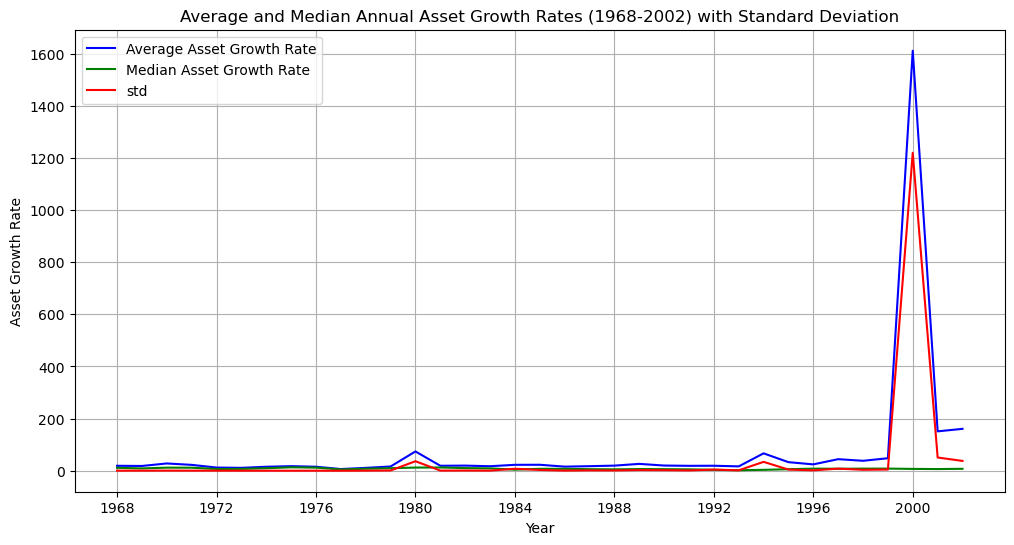

In [106]:
annual_stats = ASSETG_calculated_df.groupby('year')['ASSETG'].agg(['mean', 'median', 'std'])

plt.figure(figsize=(12, 6))

plt.plot(annual_stats.index, annual_stats['mean']*100, label='Average Asset Growth Rate', color='blue')
plt.plot(annual_stats.index, annual_stats['median']*100, label='Median Asset Growth Rate', color='green')
plt.plot(annual_stats.index, annual_stats['std'], label='std', color='red')

plt.xlabel('Year')
plt.ylabel('Asset Growth Rate')
plt.title('Average and Median Annual Asset Growth Rates (1968-2002) with Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()